In [13]:
import datetime
import random
import tracemalloc

import matplotlib.pyplot as plt
import numpy as np

INITIAL_LR = 1e-2

EPS = 1e-7

cnt = [0]

def get_eps(dim):
    return np.ones(dim) * EPS


def quadratic_grad(x, w, y, n):
    cnt[0] += n * 3 + n + 2 * n + n
    return ((x.dot(w) - y).dot(x)) / n


def quadratic_grad_l1(x, w, y, n):
    cnt[0] += n * 3 + n + 2 * n + n + 3
    return ((x.dot(w) - y).dot(x)) / n + np.sum(w / np.abs(w))


def quadratic_grad_l2(x, w, y, n):
    cnt[0] += n * 3 + n + 2 * n + n + 1
    return ((x.dot(w) - y).dot(x)) / n + np.sum(w)


def quadratic_grad_elastic(x, w, y, n, lambd1=0.5, lambd2=0.9):
    cnt[0] += n * 3 + n + 2 * n + n + 2 + 2
    return ((x.dot(w) - y).dot(x)) / n + lambd2*np.sum(w) + lambd1*np.sum(w / np.abs(w))


class StochasticGradDescCommon:
    dimensions, current, v, result, points, batch_size, gamma, learning_rate, iteration = [None] * 9

    def init(self, X_data, y_data, batch_size, gamma, learning_rate):
        self.dimensions = X_data.shape[1]
        self.current = np.zeros(self.dimensions)
        self.result = self.current
        self.points = list(zip(X_data, y_data))
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.custom_init()

    def custom_init(self):
        pass

    def update(self, batch_x, batch_y):
        pass

    def get_batches(self, points):
        random.shuffle(points)
        batch_points = points[:self.batch_size]
        batch_x = np.array(list(map(lambda x: x[0], batch_points)))
        batch_y = np.array(list(map(lambda x: x[1], batch_points)))
        return batch_x, batch_y

    def get_error(self, batch_x, batch_y):
        cnt[0] += len(batch_x) * 5
        return np.sum(np.absolute(batch_x.dot(self.current) - batch_y)) / len(batch_x)

    def get_min(self, X_data, y_data, lr_schedule, learning_rate=INITIAL_LR, gamma=0.8,
                eps=1e-4, batch_size=1, max_iter=1000):
        self.init(X_data, y_data, batch_size, gamma, learning_rate)
        self.v = np.zeros(self.dimensions)
        for i in range(max_iter):
            self.iteration = i
            batch_x, batch_y = self.get_batches(self.points)
            error = self.get_error(batch_x, batch_y)
            if error < eps:
                return self.result
            self.update(batch_x, batch_y)
            self.result = np.vstack((self.result, self.current))
            learning_rate = lr_schedule(learning_rate, i)
        return self.result


class StochasticGradDesc(StochasticGradDescCommon):
    def update(self, batch_x, batch_y):
        cnt[0] += 2 * 2
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.current -= self.learning_rate * grad


class NesterovStochasticDesc(StochasticGradDescCommon):
    def custom_init(self):
        self.v = np.zeros(self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += 6 * 2
        self.v = self.v * self.gamma + (1 - self.gamma) \
                 * quadratic_grad(batch_x, 
                                  self.current - self.learning_rate * self.gamma * self.v, 
                                  batch_y,
                                  self.dimensions)
        self.current -= self.learning_rate * self.v

class MomentumStochasticDesc(StochasticGradDescCommon):
    def custom_init(self):
        self.v = np.zeros(self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += 6 * 2
        self.v = self.v * self.gamma + (1 - self.gamma) \
                 * quadratic_grad(batch_x,
                                  self.current,
                                  batch_y,
                                  self.dimensions)
        self.current -= self.learning_rate * self.v


class AdaGradStochasticDesc(StochasticGradDescCommon):
    g = None

    def custom_init(self):
        self.g = np.zeros((self.dimensions, self.dimensions))
        self.learning_rate = 5

    def update(self, batch_x, batch_y):
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        cnt[0] += 2 * 7
        self.g += np.outer(grad, grad)
        diag = np.sqrt(self.g.diagonal())
        self.current -= self.learning_rate * grad / (diag + get_eps(self.dimensions))


class RMSStochasticDesc(StochasticGradDescCommon):
    beta = 0.8
    s = None

    def custom_init(self):
        self.beta = 0.98
        self.learning_rate = 5
        self.s = np.zeros(self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += 1 + 2 * 9
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.s = self.beta * self.s + (1 - self.beta) * grad * grad
        self.current -= self.learning_rate * grad / (np.linalg.norm(self.s) + EPS)


class AdamStochasticDesc(StochasticGradDescCommon):
    beta_one, beta_two, s = [None] * 3

    def custom_init(self):
        self.beta_one = 0.9
        self.beta_two = 0.999
        self.learning_rate = 5
        self.v = np.zeros(self.dimensions)
        self.s = np.zeros(self.dimensions)

    def get_grad(self, batch_x, batch_y):
        return quadratic_grad(batch_x, self.current, batch_y, self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += 2 * 18
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.v = self.beta_one * self.v + (1 - self.beta_one) * grad
        self.s = self.beta_two * self.s + (1 - self.beta_two) * grad * grad
        v_inv = self.v / (1 - self.beta_one ** (self.iteration + 1))
        s_inv = self.s / (1 - self.beta_two ** (self.iteration + 1))
        self.current -= self.learning_rate * v_inv / (np.linalg.norm(s_inv) + EPS)


class AdamWithL1(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_l1(batch_x, self.current, batch_y, self.dimensions)


class AdamWithL2(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_l2(batch_x, self.current, batch_y, self.dimensions)


class AdamWithElasticNet(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_elastic(batch_x, self.current, batch_y, self.dimensions)


def const_lr(learning_rate, iter_num):
    return learning_rate


def step_lr(learning_rate,
            iter_num,
            initial_lr=INITIAL_LR,
            drop=1.2,
            frequency=10):
    cnt[0] += 4
    return initial_lr * np.power(drop, np.floor((iter_num + 1) / frequency))


def exponential_lr(learning_rate,
                   iter_num,
                   initial_lr=INITIAL_LR,
                   k=1):
    cnt[0] += 3
    return initial_lr * np.exp(-k * iter_num)


def f(x):
    return 0.13 * x[0] + 4.41 * x[1]

data_size = 100
X = np.empty((data_size, 2))
Y = np.empty((data_size))
for i in range(data_size):
    x = np.random.uniform(-3, 3, 2)
    X[i] = x
    Y[i] = f(x)


def test(grad_desc, lr_scheduler, x, y):
    print()
    for batch_size in range(1, len(y) + 1):
        cnt[0] = 0
        tracemalloc.start()
        start = datetime.datetime.utcnow()
        result = grad_desc(x, y, lr_scheduler, batch_size=batch_size)
        comp_time = (datetime.datetime.utcnow() - start).total_seconds()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        values = result[-1]
        print(values)
        print(f'iterations: {len(result)}, batch_size: {batch_size}, computing_time: {comp_time}s, arithmetic operations: {cnt[0]}, peak was {peak / 10**6}MB')


def polynomial_regression(real_c, points_amount=20):
    x_points = []
    y_points = []
    xses = []
    dim = real_c.shape[0]
    for i in range(points_amount):
        x_value = float((np.random.rand(1) - 0.5) * 6)
        x_points_value = np.array([np.power(x_value, dim - 1 - i) for i in range(dim)])
        y_value = real_c.dot(x_points_value)
        x_points.append(x_points_value)
        y_points.append(y_value)
        xses.append(x_value)
    x_points = np.array(x_points)
    y_points = np.array(y_points)
    y_points += np.random.normal(0, 1, points_amount)
    tracemalloc.start()
    start = datetime.datetime.utcnow()
    result = AdamWithElasticNet().get_min(x_points, y_points, exponential_lr, batch_size=points_amount // 10)
    comp_time = (datetime.datetime.utcnow() - start).total_seconds()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(f'computing_time: {comp_time}s, peak was {peak / 10**6}MB')
    print(real_c, result[-1], len(result))
    return result[-1], (xses, y_points)


computing_time: 0.533564s, peak was 0.215598MB
[ 0.5 -5.   0.8] [ 0.42256336 -4.95074207  0.84605203] 1001


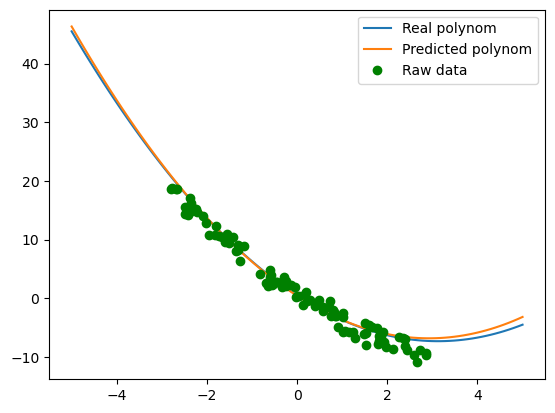

In [14]:
# constant learning rate
# test(StochasticGradDesc().get_min, exponential_lr, X, Y)
#
# # exponential learning rate
# test(MomentumStochasticDesc().get_min, exponential_lr, X, Y)
#
# # Nesterov optimisation
# test(NesterovStochasticDesc().get_min, exponential_lr, X, Y)
#
# def exponential_lr2(learning_rate,
#                    iter_num,
#                    initial_lr=5,
#                    k=5e-2):
#     return initial_lr * np.exp(-k * iter_num)
#
# # AdaGrad optimisation
# test(AdaGradStochasticDesc().get_min, exponential_lr2, X, Y)
#
# # RMSProp optimisation
# test(RMSStochasticDesc().get_min, exponential_lr2, X, Y)
#
# # Adam optimisation
# test(AdamStochasticDesc().get_min, exponential_lr2, X, Y)

# Polynomial regression
print()
coeffs = np.array([0.5, -5, 0.8])
data = polynomial_regression(coeffs, 100)
predicted_coeffs = data[0]
points = data[1]

coeffs = np.flip(coeffs)
predicted_coeffs = np.flip(predicted_coeffs)
x = np.linspace(-5, 5, 100)
y1 = [np.polyval(coeffs, i) for i in x]
y2 = [np.polyval(predicted_coeffs, i) for i in x]
plt.plot(x, y1, label='Real polynom')
plt.plot(x, y2, label='Predicted polynom')
plt.plot(points[0], points[1], 'go', label='Raw data')
plt.legend()
plt.show()


In [76]:
def test2(grad_desc, lr_scheduler, x, y):
    print()
    ops = 0
    tm = 0
    iters = 0
    mem = 0
    failed = 0
    for i in range(20):
        batch_size = len(y) // 10
        cnt[0] = 0
        tracemalloc.start()
        start = datetime.datetime.utcnow()
        result = grad_desc(x, y, lr_scheduler, batch_size=batch_size)
        comp_time = (datetime.datetime.utcnow() - start).total_seconds()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        if len(result) < 1001:
            ops += cnt[0]
            tm += comp_time
            iters += len(result)
            mem += peak / 10 ** 6
        else:
            failed += 1
    print(f'''
    iterations: {iters // (20 - failed)}
    computing_time: {tm / (20 - failed)}s
    arithmetic operations: {ops // (20 - failed)}
    memory {mem / (20 - failed)}MB
    failed: {failed}''')


def test_lr(grad_desc, lr_scheduler, x, y, title):
    xd, yd = [], []
    for batch_size in range(1, len(y) + 1):
        cnt[0] = 0
        result = grad_desc(x, y, lr_scheduler, batch_size=batch_size)
        xd.append(batch_size)
        yd.append(len(result))
    plt.plot(xd, yd)
    plt.title(title)
    plt.xlabel("Batch size")
    plt.ylabel("Iterations")
    plt.show()

# constant learning rate
test2(StochasticGradDesc().get_min, exponential_lr, X, Y)

# exponential learning rate
test2(MomentumStochasticDesc().get_min, exponential_lr, X, Y)

# Nesterov optimisation
test2(NesterovStochasticDesc().get_min, exponential_lr, X, Y)

# AdaGrad optimisation
test2(AdaGradStochasticDesc().get_min, exponential_lr2, X, Y)

# RMSProp optimisation
test2(RMSStochasticDesc().get_min, exponential_lr2, X, Y)

# Adam optimisation
test2(AdamStochasticDesc().get_min, exponential_lr2, X, Y)



    iterations: 66
    computing_time: 0.00969165s
    arithmetic operations: 4728
    memory 0.018108400000000004MB
    failed: 0


    iterations: 96
    computing_time: 0.014464699999999997s
    arithmetic operations: 7626
    memory 0.01898395MB
    failed: 0


    iterations: 85
    computing_time: 0.013880999999999996s
    arithmetic operations: 6749
    memory 0.018688600000000007MB
    failed: 0


    iterations: 11
    computing_time: 0.0022432000000000007s
    arithmetic operations: 900
    memory 0.017312699999999997MB
    failed: 0


    iterations: 17
    computing_time: 0.0029508000000000004s
    arithmetic operations: 1402
    memory 0.016710799999999998MB
    failed: 0


    iterations: 222
    computing_time: 0.042459500000000004s
    arithmetic operations: 22230
    memory 0.022987399999999998MB
    failed: 0


In [3]:
batch_x = X
batch_y = Y

def get_error(current):
    err = 0
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        err += (x[0] * current[0] + x[1] * current[1] - y) ** 2
    return err

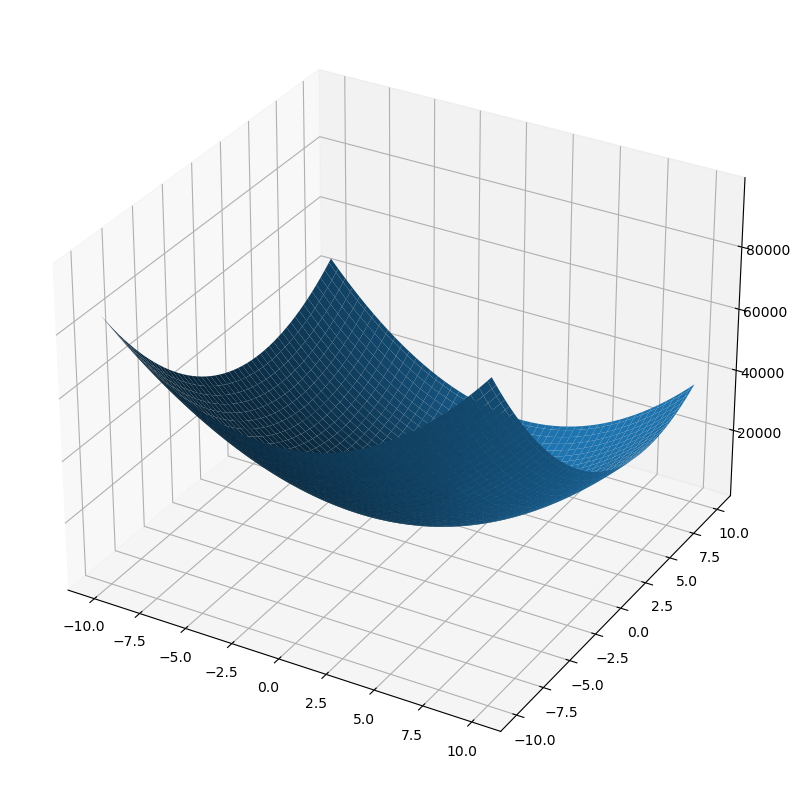

In [4]:
plt.rcParams["figure.figsize"] = (10, 10)
t = np.linspace(-10, 10, 100)
X_t, Y_t = np.meshgrid(t, t)
ax = plt.figure().add_subplot(projection="3d")
ax.plot_surface(X_t, Y_t, get_error([X_t, Y_t]))

In [5]:
def run(grad_desc, lr_scheduler, x, y):
    points = grad_desc(x, y, lr_scheduler, batch_size=5)
    points = points.reshape(points.size // 2, 2)
    plt.plot(points[:, 0], points[:, 1], 'o-')
    pnt = [get_error([p[0], p[1]]) for p in points]
    pnt = list(set(pnt))
    plt.contour(X_t, Y_t, get_error([X_t, Y_t]), levels=sorted(pnt))
    #print(points)
    print(points.size // 2)

156


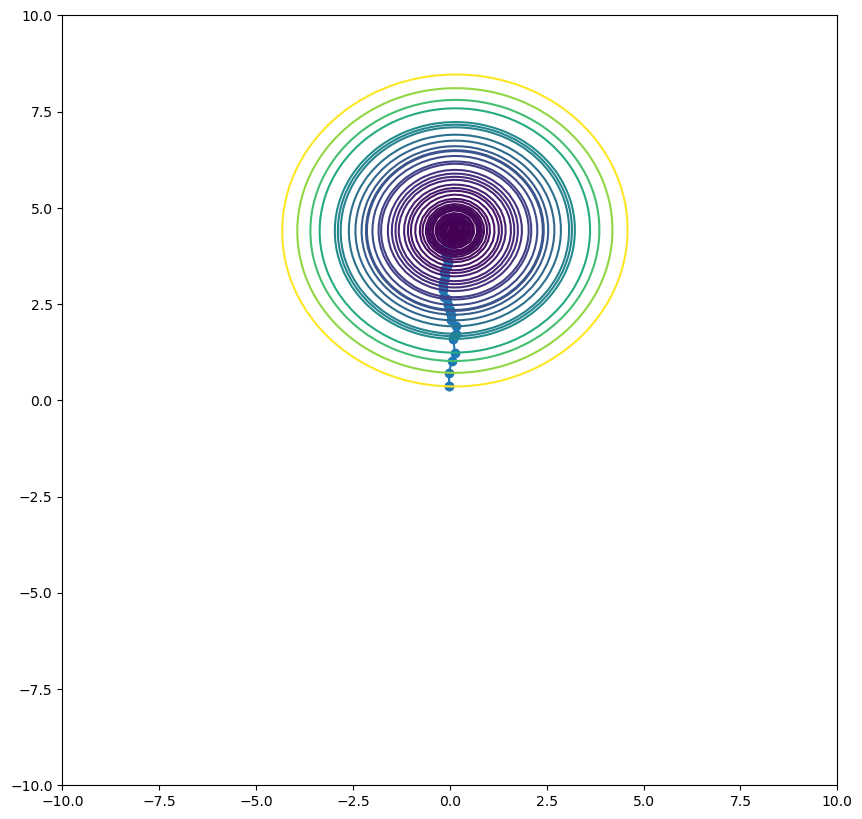

In [9]:
run(StochasticGradDesc().get_min, exponential_lr, X, Y)

94


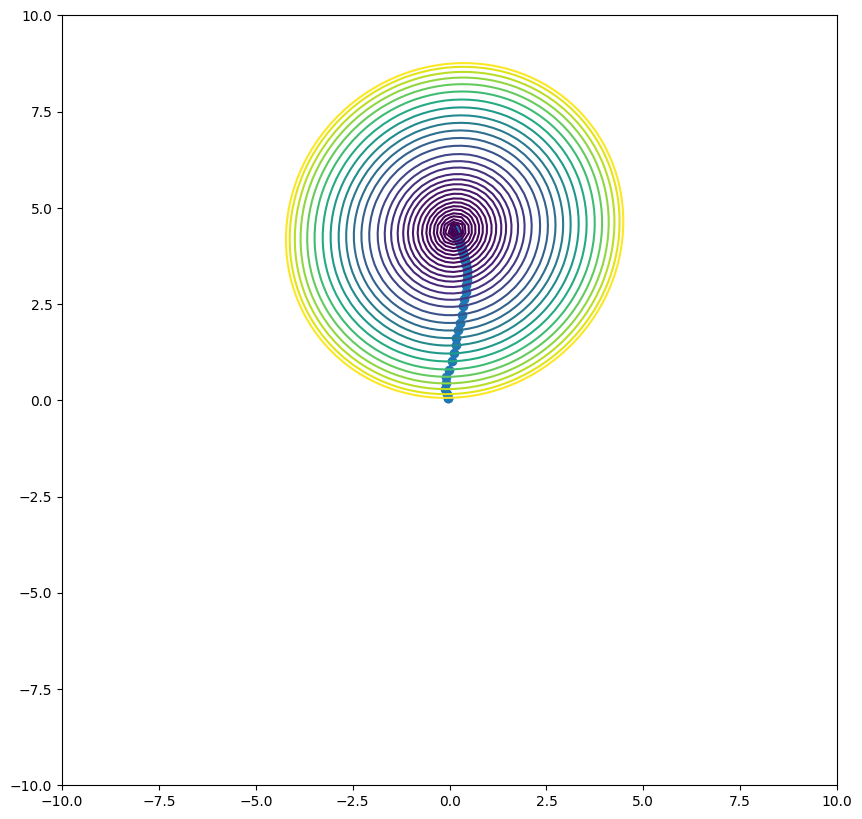

In [68]:
run(NesterovStochasticDesc().get_min, const_lr, X, Y)

88


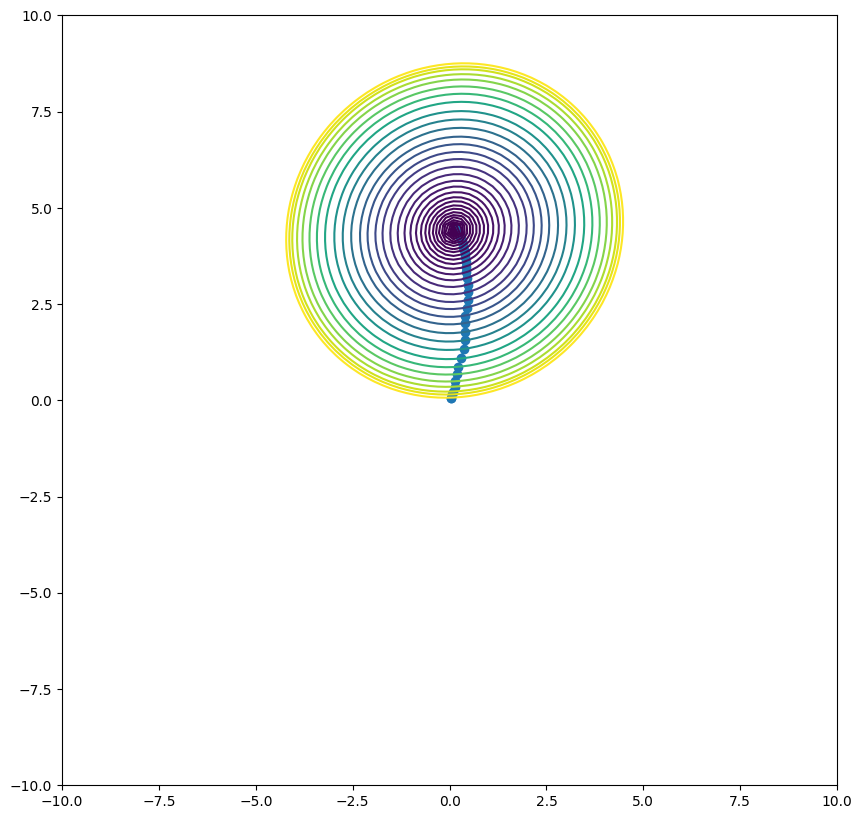

In [69]:
run(MomentumStochasticDesc().get_min, const_lr, X, Y)

18


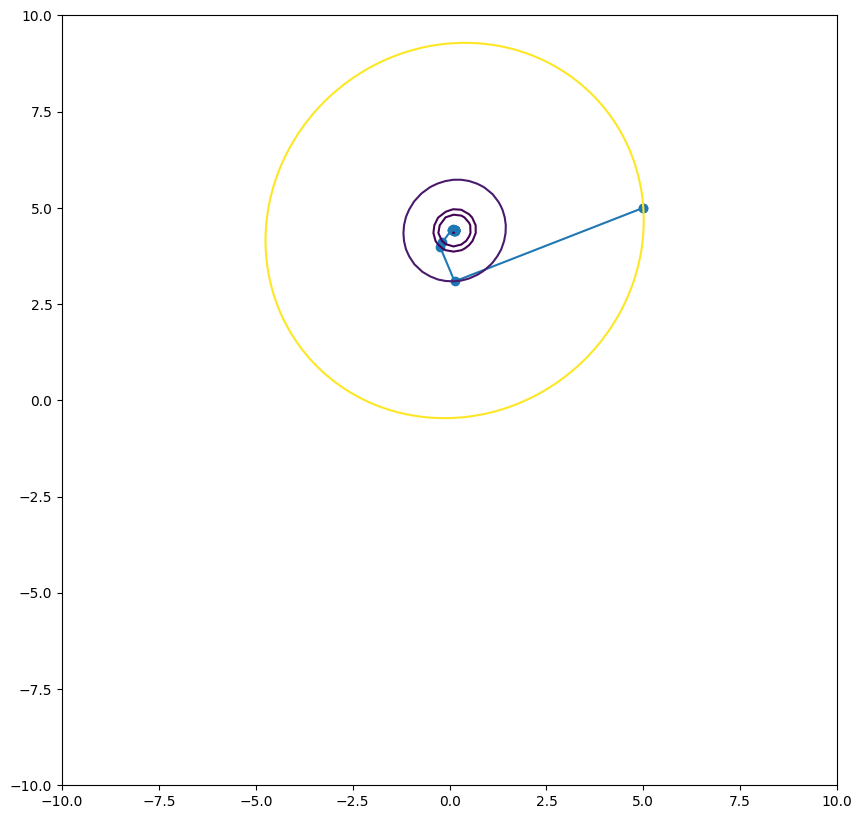

In [70]:
run(AdaGradStochasticDesc().get_min, const_lr, X, Y)

52


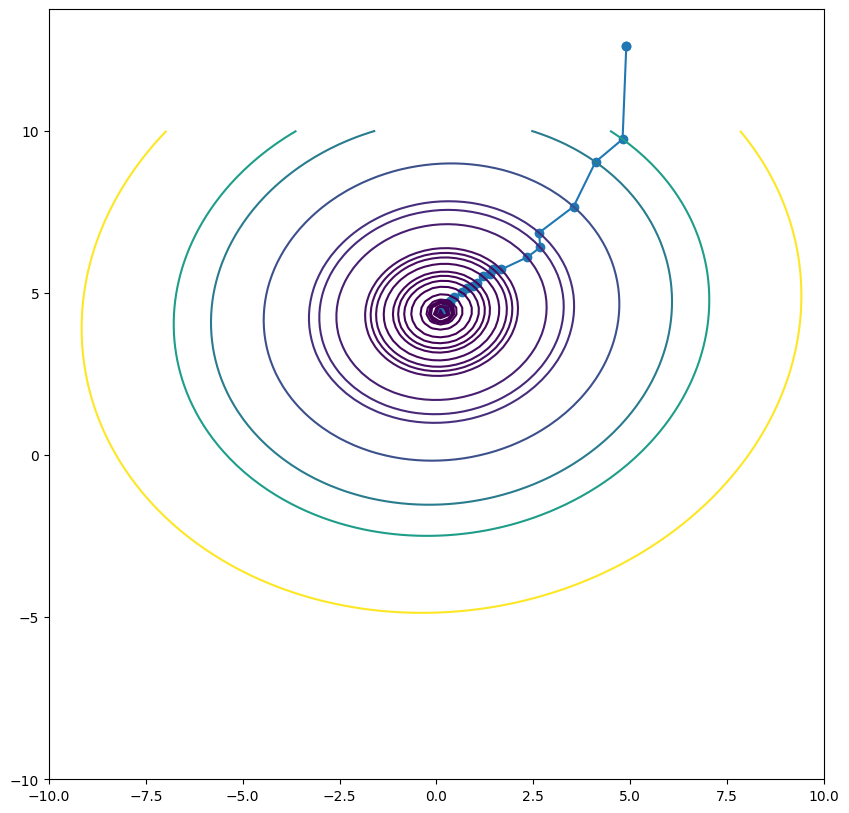

In [71]:
run(RMSStochasticDesc().get_min, exponential_lr, X, Y)

224


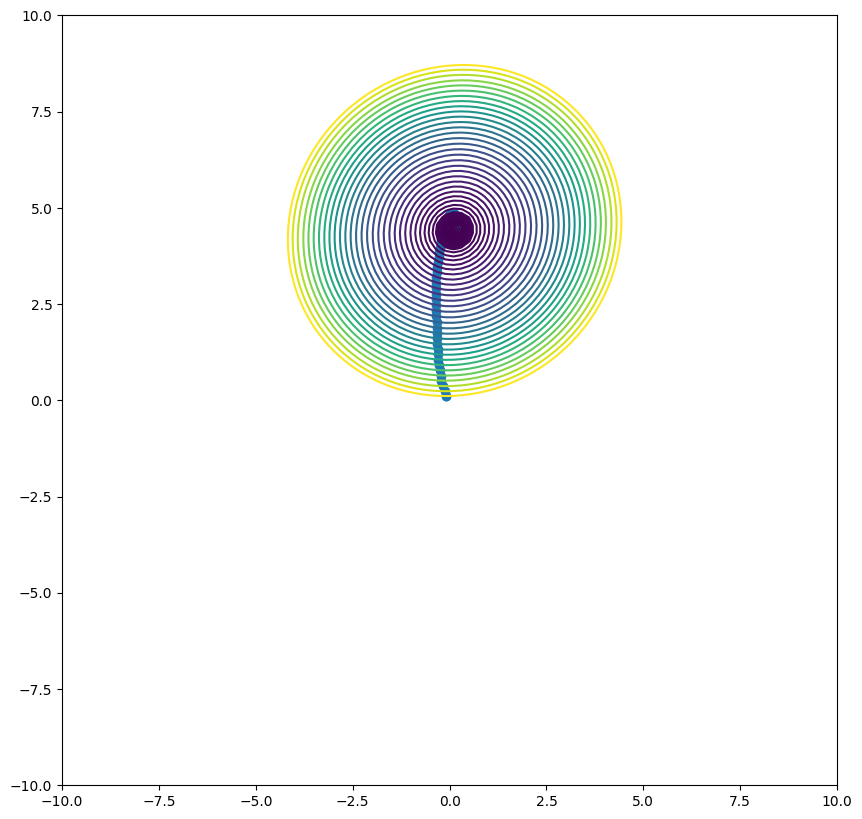

In [72]:
run(AdamStochasticDesc().get_min, const_lr, X, Y)